
RUNNING ANALYSIS FOR: BINARY CLASSIFICATION

Training data shape: (4292, 131) (Years before 2022)
Validation data shape: (1191, 131) (Years 2022+)

Class distribution in Training data:
Pct_Inc_Total_Revenue_Next_Year
1    0.722041
0    0.277959
Name: proportion, dtype: float64

Top 30 selected features:
- Acute_Care_Total_Discharges
- Acute_Care_Medicare_Patient_Days
- Acute_Care_Other_Patient_Days
- Acute_Care_Total_Patient_Days
- Swing_Bed_Other_Patient_Days
- SNF_Other_Patient_Days
- Total_Inpatient_Surgeries
- Number_of_Admissions_from_ER
- Emergency_Room_Visits
- Observation_Visits
- Acute_Other_Inpatient_Revenue
- Acute_Total_Inpatient_Revenue
- Acute_Medicare_Outpatient_Revenue
- Acute_Medicaid_Outpatient_Revenue
- Acute_Other_Outpatient_Revenue
- Acute_Total_Outpatient_Revenue
- Acute_Contractuals_Total
- Total_Charity_Care
- Facility_Payroll
- Facility_Paid_Hours
- Total_Payroll
- Total_Paid_Hours
- Employee_Benefit_Expenses
- Supply_Expenses
- Depreciation_Expense
- Bad_Debt

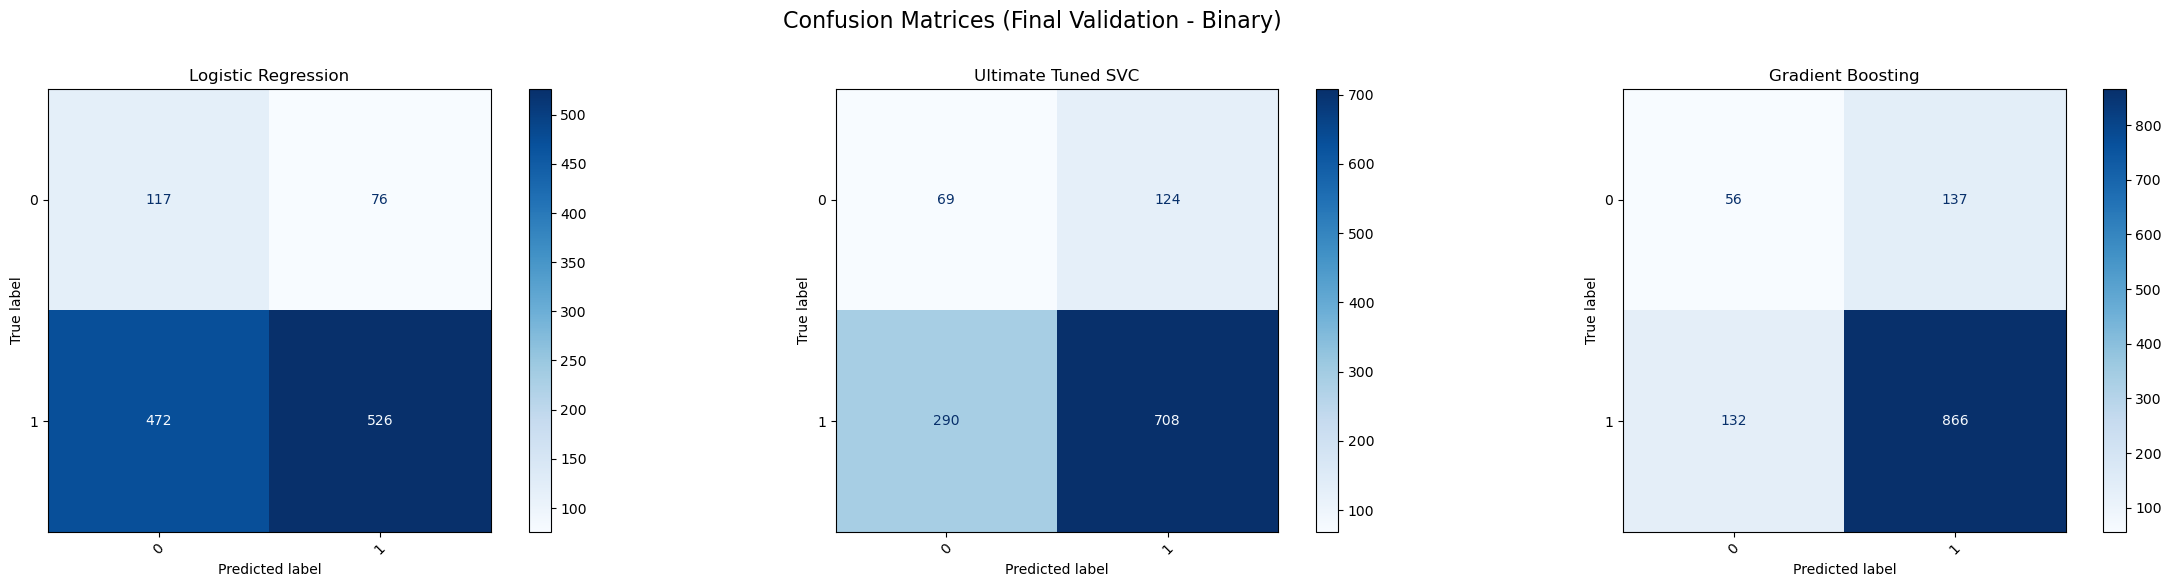


RUNNING ANALYSIS FOR: MULTICLASS CLASSIFICATION

Training data shape: (4292, 131) (Years before 2022)
Validation data shape: (1191, 131) (Years 2022+)

Class distribution in Training data:
Pct_Inc_Total_Revenue_Next_Year
Healthy Growth    0.326887
Decline           0.277959
High Growth       0.199907
Slow Growth       0.195247
Name: proportion, dtype: float64

Top 30 selected features:
- Licensed_Beds
- Acute_Care_Medicare_Discharges
- Acute_Care_Medicaid_Discharges
- Acute_Care_Total_Discharges
- Total_Medicare_Discharges
- Total_Medicaid_Discharges
- Total_Discharges
- Acute_Care_Medicare_Patient_Days
- Acute_Care_Total_Patient_Days
- Total_Medicare_Patient_Days
- Total_Patient_Days
- Total_Inpatient_Surgeries
- Total_Births
- Number_of_Admissions_from_ER
- Emergency_Room_Visits
- Outpatient_Surgery_Visits
- Observation_Visits
- All_Other_Visits
- Total_Outpatient_Visits
- Acute_Medicare_Inpatient_Revenue
- Acute_Total_Inpatient_Revenue
- Acute_Other_Outpatient_Revenue
- Acute_Total

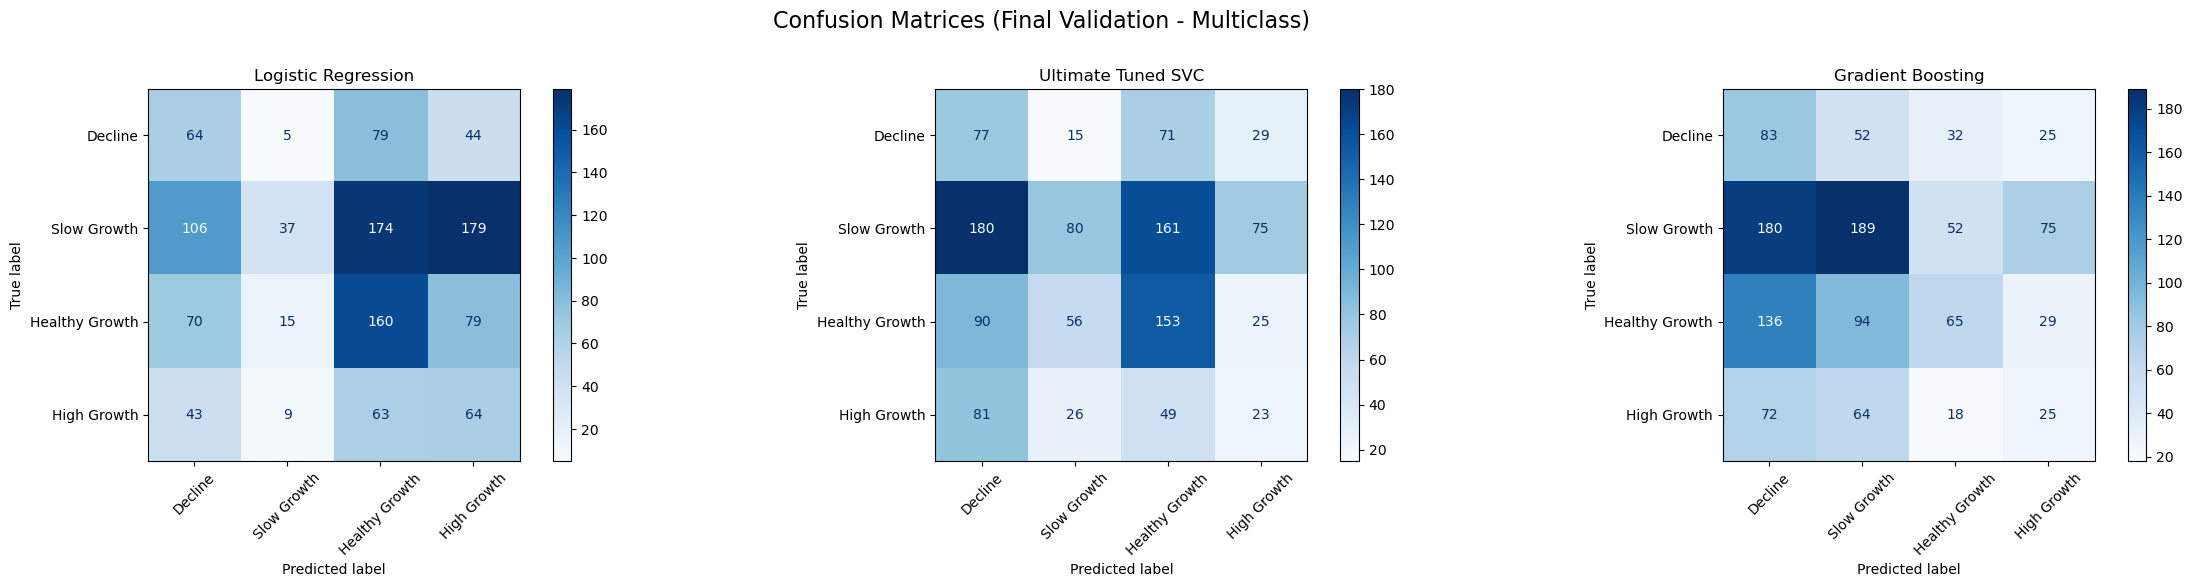

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt

# --- Data Loading ---
os.chdir('C:/school/labs')
df = pd.read_csv('oregon_washington_combined_data.csv')

# --- Preprocessing Functions ---

def preprocess_data(df, problem_type='binary'):
    """Prepares data for either binary or multi-class classification."""
    
    # Keep 'Year' for splitting, drop other non-numeric/leaky columns
    cols_to_drop = ['Hospital_License_or_AHA', 'Hospital_Name', 'Quarter', 'State', 'Next_Year_Total_Revenue']
    df = df.drop(columns=cols_to_drop)
    
    # Clean the target variable before any processing
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna(subset=['Pct_Inc_Total_Revenue_Next_Year'])
    df = df[np.abs(df['Pct_Inc_Total_Revenue_Next_Year']) < 100]

    if problem_type == 'binary':
        y = (df['Pct_Inc_Total_Revenue_Next_Year'] > 0).astype(int)
    elif problem_type == 'multiclass':
        bins = [-np.inf, 0, 5, 15, np.inf]
        labels = ["Decline", "Slow Growth", "Healthy Growth", "High Growth"]
        y = pd.cut(df['Pct_Inc_Total_Revenue_Next_Year'], bins=bins, labels=labels, right=False)
    else:
        raise ValueError("problem_type must be 'binary' or 'multiclass'")
        
    X = df.drop(columns=['Pct_Inc_Total_Revenue_Next_Year'])
    X = X.fillna(X.mean())
    
    return X, y

# --- Core Modeling Functions ---

def select_features(X, y, k=30):
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X, y)
    selected_cols = X.columns[selector.get_support()]
    print(f"\nTop {k} selected features:")
    for feature in selected_cols:
        print(f"- {feature}")
    return selected_cols

def get_models():
    """Returns a dictionary of classification models to be evaluated."""
    
    svc_pipeline = Pipeline([('scaler', RobustScaler()), ('model', SVC(random_state=42))])
    svc_param_grid = [
        {'model__kernel': ['rbf'], 'model__C': [10, 50], 'model__gamma': ['scale', 0.1], 'model__class_weight': ['balanced']},
        {'model__kernel': ['poly'], 'model__degree': [2], 'model__C': [10, 50], 'model__class_weight': ['balanced']}
    ]
    svc_grid_search = GridSearchCV(svc_pipeline, param_grid=svc_param_grid, cv=3, n_jobs=-1, scoring='accuracy')

    models = {
        "Logistic Regression": Pipeline([('scaler', RobustScaler()), ('model', LogisticRegression(random_state=42, class_weight='balanced'))]),
        "Ultimate Tuned SVC": svc_grid_search,
        "Gradient Boosting": HistGradientBoostingClassifier(random_state=42)
    }
    return models

def plot_confusion_matrices(results, title_suffix=''):
    """Plots confusion matrices for a set of model results."""
    num_models = len(results)
    fig, axes = plt.subplots(1, num_models, figsize=(8 * num_models, 6))
    if num_models == 1: axes = [axes]
    
    fig.suptitle(f'Confusion Matrices ({title_suffix})', fontsize=16)
    
    for ax, (model_name, data) in zip(axes, results.items()):
        display_labels = data.get('display_labels')
        ConfusionMatrixDisplay.from_predictions(data['y_true'], data['y_pred'], ax=ax, cmap='Blues', display_labels=display_labels)
        ax.set_title(f'{model_name}')
        ax.tick_params(axis='x', labelrotation=45)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Main Analysis Runner ---

def run_analysis(df, problem_type):
    """Runs the entire pipeline for a given classification problem."""
    
    print("\n" + "="*80)
    print(f"RUNNING ANALYSIS FOR: {problem_type.upper()} CLASSIFICATION")
    print("="*80 + "\n")
    
    # 1. Preprocess and Split Data by Time
    X, y = preprocess_data(df.copy(), problem_type=problem_type)
    
    train_mask = X['Year'] < 2022
    val_mask = X['Year'] >= 2022
    
    X_train, y_train = X[train_mask].drop(columns='Year'), y[train_mask]
    X_val, y_val = X[val_mask].drop(columns='Year'), y[val_mask]
    
    print(f"Training data shape: {X_train.shape} (Years before 2022)")
    print(f"Validation data shape: {X_val.shape} (Years 2022+)")
    print("\nClass distribution in Training data:")
    print(y_train.value_counts(normalize=True))
    
    # 2. Feature Selection (on training data only)
    selected_cols = select_features(X_train, y_train, k=30)
    X_train_selected = X_train[selected_cols]
    X_val_selected = X_val[selected_cols]
    
    # 3. Train, Test (on pre-2022), and Validate (on post-2022)
    models = get_models()
    validation_results = {}
    
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        # Train on a split of the pre-2022 data to get a test score
        X_t, X_test, y_t, y_test = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=42, stratify=y_train)
        model.fit(X_t, y_t)
        y_pred_test = model.predict(X_test)
        print("\nPerformance on TEST set (pre-2022 data):")
        print(classification_report(y_test, y_pred_test, zero_division=0))

        # Now, retrain on ALL pre-2022 data for final validation
        print("Retraining on all pre-2022 data...")
        model.fit(X_train_selected, y_train)
        
        # Evaluate on the post-2022 validation set
        y_pred_val = model.predict(X_val_selected)
        print("\nPerformance on FINAL VALIDATION set (post-2022 data):")
        print(classification_report(y_val, y_pred_val, zero_division=0))
        
        validation_results[name] = {
            'y_true': y_val, 
            'y_pred': y_pred_val,
            'display_labels': y_val.cat.categories if problem_type == 'multiclass' else None
        }
        
    # 4. Plot final validation confusion matrices
    plot_confusion_matrices(validation_results, title_suffix=f"Final Validation - {problem_type.capitalize()}")

# --- Script Entry Point ---

def main():
    """Main function to run both binary and multi-class analyses."""
    run_analysis(df, 'binary')
    run_analysis(df, 'multiclass')

if __name__ == "__main__":
    main() 